In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error, r2_score

In [18]:
df=pd.read_csv("train.csv")
df.head(5)

,bedroom,bathrooms,area,furnishing,avalable_for,address,floor_number,facing,floor_type,gate_community,...,pooja_room,study_room,others,servant_room,store_room,maintenance_amt,brok_amt,deposit_amt,mnt_amt,rent
0,2,2,1050.0,Unfurnished,All,"Sadguru hights, Pingale Wasti, , Pune, Maharas...",5,West,Marble,Yes,...,0,0,0,0,0,0,0,3,0.0,20000.0
1,2,2,760.0,Unfurnished,All,"Manav Silver Springs, Wagholi, , Pune, Maharas...",5,East,Vitrified,Yes,...,0,0,0,0,0,0,0,40000,0.0,14000.0
2,3,3,0.0,Semifurnished,All,"Saarrthi Souvenir, Mahalunge, , Pune, Maharashtra",1,South-West,Vitrified,Yes,...,0,0,1,0,0,Maintenance 1/ (/ month,23000,60000,1.0,22999.0
3,1,1,628.0,Furnished,Family Only,"Dhan Residency, Wanowrie, , Pune, Maharashtra",3,East,Mosaic,Yes,...,0,0,0,0,0,0,0,40000,0.0,13000.0
4,2,2,668.0,Semifurnished,"Family , Bachelors (Men Only)","Saptsiddhi Savali Homes, Uruli Devachi, , Pune...",6,South,Polished concrete,Yes,...,0,0,0,0,0,0,0,20,0.0,7500.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10884 entries, 0 to 10883
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedroom            10884 non-null  int64  
 1   bathrooms          10884 non-null  int64  
 2   area               10884 non-null  float64
 3   furnishing         10884 non-null  object 
 4   avalable_for       10854 non-null  object 
 5   address            10884 non-null  object 
 6   floor_number       10884 non-null  int64  
 7   facing             10884 non-null  object 
 8   floor_type         10884 non-null  object 
 9   gate_community     10884 non-null  object 
 10  corner_pro         10884 non-null  object 
 11  parking            10884 non-null  int64  
 12  wheelchairadption  1944 non-null   object 
 13  petfacility        2426 non-null   object 
 14  aggDur             10884 non-null  int64  
 15  noticeDur          10884 non-null  int64  
 16  lightbill          108

In [20]:
##Categorical Features to be converted to numerical-
## furnishing, available_for, address, facing, floor_type, gate_community, corner_pro, wheelchairadption, petfacility, propertyage, maintenance_amt

df['furnishing'].unique()
df['furnishing']=df['furnishing'].map({'Unfurnished':0, 'Semifurnished':1, 'Furnished':2, 'Unfurnishe':0})

df['avalable_for'].unique()

#Substitute missing values with Mode
df['avalable_for'].isna().sum()
df['avalable_for'].value_counts().index[0]
df['avalable_for']=df['avalable_for'].fillna(df['avalable_for'].value_counts().index[0])
df['avalable_for'].unique()

#Label Encoding
df['avalable_for']=df['avalable_for'].map({'All':7, 'Family Only':6, 'Family , Bachelors (Men Only)':4,
       'Family , Bachelors (Women Only)':5, 'Bachelors (Men/Women)':2,
       'Bachelors (Women Only)':3, 'Bachelors (Men Only)':1})

#Drop Address Column due to many locations
df['location']=df['address'].str.split(",").str[1]
df.drop(['address'],axis=1,inplace=True)

df['facing'].unique()
pd.get_dummies(df['facing'])
df=df.join(pd.get_dummies(df['facing'],dtype=int))
df.drop(['facing'],inplace=True,axis=1)

df['floor_type'].unique()
df['Floor_type_order']=df['floor_type'].map({'Marble':14, 'Vitrified':10, 'Mosaic':8, 'Polished concrete':9, 'Ceramic':7,'Not provided':0, 'Wood':12, 'Stone':11, 'Spartex':6, 'Others':1, 'Granite':13,'Vinyl':5, 'Concrete':4, 'Cement':2, 'IPSFinish':3})
df['Floor_type_order']
df.drop(['floor_type'],axis=1,inplace=True)

df['gate_community'].unique()
df['gate_community']=df['gate_community'].replace({'Yes':1,'No':0})
df['gate_community']

df['corner_pro'].unique()
df['corner_pro']=df['corner_pro'].replace({'Yes':1,'No':0})

df['wheelchairadption'].unique()
df['wheelchairadption']=df['wheelchairadption'].replace({None:0,'Yes':1})

df['petfacility'].unique()
df['petfacility']=df['petfacility'].replace({None:0,'Yes':1})

df['propertyage'].unique()
df['propertyage']=df['propertyage'].map({'5 to 10 Year Old':4, '1 to 5 Year Old':3, '10+ Year Old':5, '0 to 1 Year Old':2, 'Under Construction':1, 'NO age':0})

df['maintenance_amt']=df['maintenance_amt'].str.split('/').str[0].str.split(" ").str[1].values
df['maintenance_amt']=df['maintenance_amt'].fillna(0)
df['maintenance_amt']=df['maintenance_amt'].astype(int)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10884 entries, 0 to 10883
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedroom            10884 non-null  int64  
 1   bathrooms          10884 non-null  int64  
 2   area               10884 non-null  float64
 3   furnishing         10884 non-null  int64  
 4   avalable_for       10884 non-null  int64  
 5   floor_number       10884 non-null  int64  
 6   gate_community     10884 non-null  int64  
 7   corner_pro         10884 non-null  int64  
 8   parking            10884 non-null  int64  
 9   wheelchairadption  10884 non-null  int64  
 10  petfacility        10884 non-null  int64  
 11  aggDur             10884 non-null  int64  
 12  noticeDur          10884 non-null  int64  
 13  lightbill          10884 non-null  int64  
 14  powerbackup        10884 non-null  int64  
 15  propertyage        10884 non-null  int64  
 16  no_room            108

Original: 10884 rows
Cleaned: 10435 rows
Percentage of Entries removed- 4.125321572951121 %


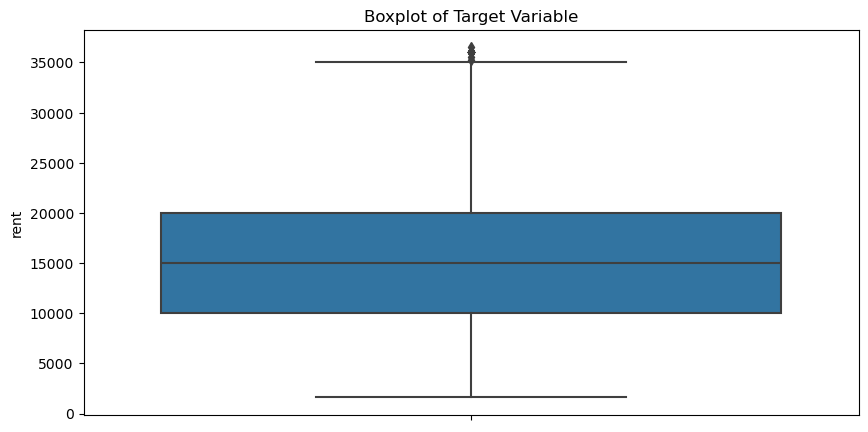

In [22]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df,feature, factor):
    
    # Compute Q1, Q3, and IQR for each column
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    df_clean = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

    return df_clean

# Apply function
cleaned_df = remove_outliers_iqr(df,feature='rent',factor=1.5)

# Print results
print(f"Original: {len(df)} rows")
print(f"Cleaned: {len(cleaned_df)} rows")
print("Percentage of Entries removed-",((len(df)-len(cleaned_df))/len(df))*100,"%")

plt.figure(figsize=(10, 5))
sns.boxplot(y=cleaned_df['rent'])
plt.title("Boxplot of Target Variable")
plt.show()

<Axes: >

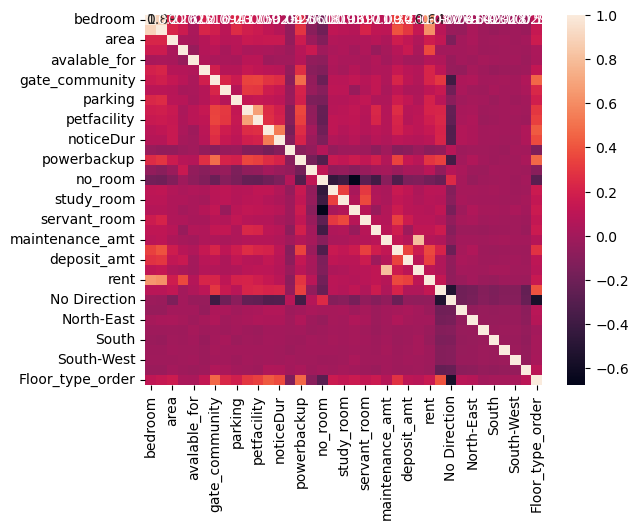

In [23]:
sns.heatmap(cleaned_df.corr(numeric_only=True),annot=True)

In [24]:
#Multicollinearity- Dropping features that are too related to each other

def remove_highly_correlated_features(df, threshold):
    # Calculate the correlation matrix
    corr_matrix = df.corr(numeric_only=True).abs()

    # Get upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop the features
    df_reduced = df.drop(columns=to_drop)

    return df_reduced, to_drop

reduced_df,deleted_columns=remove_highly_correlated_features(cleaned_df,threshold=0.9)
deleted_columns

[]

In [25]:
#Setting dataframe to new cleaned and reduced dataframe
df=reduced_df

In [26]:
#Target Encoding for Location, and Train Test Splitting

# Split before encoding
X = df.drop(columns=['rent'])
y = df['rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Target encoding: Calculate mean rent per location
location_mean = y_train.groupby(X_train['location']).mean()
global_mean = y_train.mean()

# Apply encoding to train
X_train['location_encoded'] = X_train['location'].map(location_mean)
# Apply encoding to test (fallback to global mean)
X_test['location_encoded'] = X_test['location'].map(location_mean).fillna(global_mean)

# Drop original 'location' column
X_train = X_train.drop(columns=['location'])
X_test = X_test.drop(columns=['location'])

# Save column order for prediction
feature_columns = X_train.columns.tolist()

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=feature_columns)
X_test = pd.DataFrame(X_test, columns=feature_columns)

In [39]:
#Model Training and Accuracy

xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mse=mean_squared_error(y_test, y_pred)
mae=mean_absolute_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)
print("RMSE:", rmse)
print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)

RMSE: 2820.9338497448925
MSE: 7957667.784636539
MAE: 1934.5342981810763
R2 Score: 0.8367553447219529
